In [1]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (6,6)
plt.rcParams["font.size"] = 16.0

import numpy as np
np.random.seed = 333

In [2]:
import os
os.environ['KERAS_BACKEND'] = 'theano'

# Prepare data

In [3]:
from carl.distributions import Mixture, MultivariateNormal, Uniform, Normal

p0 = MultivariateNormal(mu=np.array([0., 0.]), sigma=np.array([[1., -0.5], [-0.5, 1.]]))
p1 = MultivariateNormal(mu=np.array([1., 1.]), sigma=np.eye(2))
pz = Normal(mu=0.0, sigma=1.0)

In [4]:
n_samples = 125000

X0 = p0.rvs(n_samples // 2)
X1 = p1.rvs(n_samples // 2)
z = pz.rvs(n_samples).ravel()
X1[:, 1] += z[n_samples // 2:]

X = np.vstack([X0, X1])
y = np.zeros(n_samples)
y[n_samples // 2:] = 1

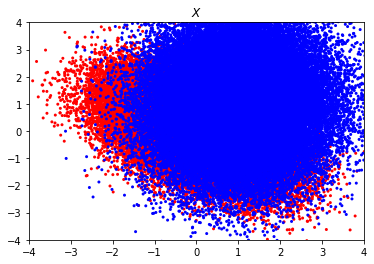

In [5]:
plt.title("$X$")
plt.scatter(X[y==0, 0], X[y==0, 1], c="r", marker=".", edgecolors="none")
plt.scatter(X[y==1, 0], X[y==1, 1], c="b", marker=".", edgecolors="none")
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.show()

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid, z_train, z_valid = train_test_split(X, y, z, test_size=50000)

# Set network architectures

In [7]:
import keras.backend as K
from keras.layers import Input, Dense, Lambda, Concatenate, merge
from keras.models import Model

inputs = Input(shape=(X.shape[1],))
Dx = Dense(20, activation="tanh")(inputs)
Dx = Dense(20, activation="relu")(Dx)
Dx = Dense(1, activation="sigmoid")(Dx)
D = Model(inputs=[inputs], outputs=[Dx])

n_components = 5
Rx = D(inputs)
Rx = Dense(20, activation="relu")(Rx)
Rx = Dense(20, activation="relu")(Rx)
mu = Dense(n_components, activation="linear")(Rx)
sigma = Dense(n_components, activation=K.exp)(Rx)
pi = Dense(n_components, activation="softmax")(Rx)
Rx = Concatenate()([mu, sigma, pi])

R = Model(inputs=[inputs], outputs=[Rx])

Using Theano backend.


In [8]:
from keras.optimizers import SGD
import keras.backend as K
import theano.tensor as T

lam = 50.0 

def make_loss_D(c):
    def loss_D(y_true, y_pred):
        return c * K.binary_crossentropy(y_true, y_pred)
    return loss_D

def make_loss_R(lam, n_components):
    def loss(y_true, y_pred):
        y_true = y_true.ravel()
        
        mu = y_pred[:, :n_components]
        sigma = y_pred[:, n_components:2*n_components]
        pi = y_pred[:, 2*n_components:]
        
        pdf = pi[:, 0] * ((1. / np.sqrt(2. * np.pi)) / sigma[:, 0] *
                          K.exp(-(y_true - mu[:, 0]) ** 2 / (2. * sigma[:, 0] ** 2)))
        
        for c in range(1, n_components):
            pdf += pi[:, c] * ((1. / np.sqrt(2. * np.pi)) / sigma[:, c] *
                               K.exp(-(y_true - mu[:, c]) ** 2 / (2. * sigma[:, c] ** 2)))
            
        nll = -K.log(pdf)
        
        return lam * nll.mean()
    
    return loss

opt_D = SGD()
D.compile(loss=[make_loss_D(c=1.0)], optimizer=opt_D)

opt_DRf = SGD(momentum=0.0)
DRf = Model(inputs=[inputs], outputs=[D(inputs), R(inputs)])
DRf.compile(loss=[make_loss_D(c=1.0), 
                  make_loss_R(-lam, n_components)],   
            optimizer=opt_DRf)

opt_DfR = SGD(momentum=0.0)
DfR = Model(inputs=[inputs], outputs=[R(inputs)])
DfR.compile(loss=[make_loss_R(1.0, n_components)], 
            optimizer=opt_DfR)

In [9]:
DRf.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 2)            0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 1)            501         input_1[0][0]                    
__________________________________________________________________________________________________
model_2 (Model)                 (None, 15)           1276        input_1[0][0]                    
Total params: 1,276
Trainable params: 1,276
Non-trainable params: 0
__________________________________________________________________________________________________


In [10]:
DfR.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
model_2 (Model)              (None, 15)                1276      
Total params: 1,276
Trainable params: 1,276
Non-trainable params: 0
_________________________________________________________________


# Pre-training without adversary

In [11]:
# Pretraining of D
D.trainable = True
R.trainable = False
D.fit(X_train, y_train, epochs=50)
min_Lf = D.evaluate(X_valid, y_valid)

Epoch 1/50
75000/75000 [==============================] - 1s 16us/step - loss: 0.4778
Epoch 2/50
75000/75000 [==============================] - 1s 16us/step - loss: 0.4537
Epoch 3/50
75000/75000 [==============================] - 1s 16us/step - loss: 0.4526
Epoch 4/50
75000/75000 [==============================] - 1s 17us/step - loss: 0.4523
Epoch 5/50
75000/75000 [==============================] - 1s 16us/step - loss: 0.4519
Epoch 6/50
75000/75000 [==============================] - 1s 16us/step - loss: 0.4515
Epoch 7/50
75000/75000 [==============================] - 1s 17us/step - loss: 0.4512
Epoch 8/50
75000/75000 [==============================] - 1s 17us/step - loss: 0.4508
Epoch 9/50
75000/75000 [==============================] - 1s 16us/step - loss: 0.4505
Epoch 10/50
75000/75000 [==============================] - 1s 17us/step - loss: 0.4501
Epoch 11/50
75000/75000 [==============================] - 1s 17us/step - loss: 0.4498
Epoch 12/50
75000/75000 [===========================

In [12]:
def make_X(n_samples, z):
    X0 = p0.rvs(n_samples // 2)
    X1 = p1.rvs(n_samples // 2)
    X1[:, 1] += z
    X = np.vstack([X0, X1])
    y = np.zeros(n_samples)
    y[n_samples // 2:] = 1
    return X

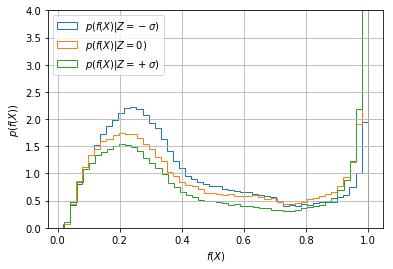

In [13]:
plt.hist(D.predict(make_X(200000, z=-1)), bins=50, density=1, histtype="step", label="$p(f(X)|Z=-\sigma)$")
plt.hist(D.predict(make_X(200000, z=0)), bins=50, density=1, histtype="step", label="$p(f(X)|Z=0)$")
plt.hist(D.predict(make_X(200000, z=1)), bins=50, density=1, histtype="step", label="$p(f(X)|Z=+\sigma)$")
plt.legend(loc="best")
plt.ylim(0,4)
plt.xlabel("$f(X)$")
plt.ylabel("$p(f(X))$")
plt.grid()
plt.legend(loc="upper left")
plt.savefig("f-plain.pdf")
plt.show()

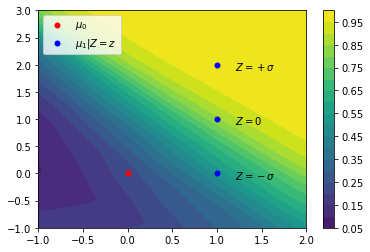

In [14]:
from scipy.interpolate import griddata

X_test = np.random.rand(30000, 2)
X_test[:, 0] *= 10. 
X_test[:, 0] -= 5.
X_test[:, 1] *= 10. 
X_test[:, 1] -= 5.

y_pred = D.predict(X_test).ravel()

xi = np.linspace(-1., 2., 100)
yi = np.linspace(-1., 3, 100)
gxi, gyi = np.meshgrid(xi, yi)
zi = griddata(X_test, y_pred, (gxi.ravel(), gyi.ravel()), method="linear")
CS = plt.contourf(xi, yi, zi.reshape(len(xi), len(yi)), 20, cmap=plt.cm.viridis,
                  vmax=1.0, vmin=0.0)
plt.colorbar() 
plt.scatter([0], [0], c="red", linewidths=0, label=r"$\mu_0$")
plt.scatter([1], [0], c="blue", linewidths=0, label=r"$\mu_1|Z=z$")
plt.scatter([1], [0+1], c="blue", linewidths=0)
plt.scatter([1], [0+2], c="blue", linewidths=0)
plt.text(1.2, 0-0.1, "$Z=-\sigma$", color="k")
plt.text(1.2, 1-0.1, "$Z=0$", color="k")
plt.text(1.2, 2-0.1, "$Z=+\sigma$", color="k")
plt.xlim(-1,2)
plt.ylim(-1,3)
plt.legend(loc="upper left", scatterpoints=1)
plt.savefig("surface-plain.pdf")
plt.show()

# Adversarial training of f and r

In [15]:
# Pretraining of R
D.trainable = False
R.trainable = True
DfR.fit(X_train, z_train, epochs=20)

/home/carlos/.local/lib/python3.6/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch 1/20
75000/75000 [==============================] - 3s 39us/step - loss: 1.3971
Epoch 2/20
75000/75000 [==============================] - 3s 41us/step - loss: 1.3381
Epoch 3/20
75000/75000 [==============================] - 3s 35us/step - loss: 1.3221
Epoch 4/20
75000/75000 [==============================] - 3s 35us/step - loss: 1.3186
Epoch 5/20
75000/75000 [==============================] - 3s 38us/step - loss: 1.3168
Epoch 6/20
75000/75000 [==============================] - 3s 35us/step - loss: 1.3158
Epoch 7/20
75000/75000 [==============================] - 3s 36us/step - loss: 1.3152
Epoch 8/20
75000/75000 [==============================] - 3s 36us/step - loss: 1.3148
Epoch 9/20
75000/75000 [==============================] - 3s 36us/step - loss: 1.3144
Epoch 10/20
75000/75000 [==============================] - 3s 36us/step - loss: 1.3141
Epoch 11/20
75000/75000 [==============================] - 3s 37us/step - loss: 1.3139
Epoch 12/20
75000/75000 [===========================

In [16]:
from IPython import display

min_Lr = np.log(1 * (2. * np.pi * np.e) ** 0.5)

def plot_losses(i, losses):
    display.clear_output(wait=True)
    display.display(plt.gcf())

    ax1 = plt.subplot(311)   
    values = np.array(losses["L_f"])
    plt.plot(range(len(values)), values, label=r"$L_f$", color="blue")
    plt.legend(loc="upper right")
    
    ax2 = plt.subplot(312, sharex=ax1) 
    values = np.array(losses["L_r"]) / lam
    plt.plot(range(len(values)), values, label=r"$L_r$", color="green")
    plt.legend(loc="upper right")
    
    ax3 = plt.subplot(313, sharex=ax1)
    values = np.array(losses["L_f - L_r"])
    plt.plot(range(len(values)), values, label=r"$L_f - \lambda L_r$", color="red")  
    plt.legend(loc="upper right")
    
    plt.show()  

In [17]:
losses = {"L_f": [], "L_r": [], "L_f - L_r": []}

<Figure size 432x288 with 0 Axes>

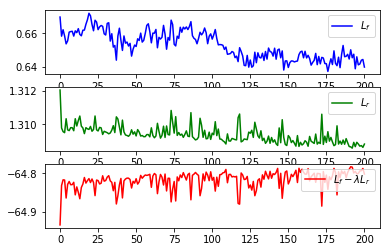

Epoch 1/1
75000/75000 [==============================] - 1s 14us/step - loss: 1.3112


In [18]:
batch_size = 128

for i in range(201):
    l = DRf.evaluate(X_valid, [y_valid, z_valid], verbose=0)
    #losses["L_f - L_r"].append(l[0][None][0])
    losses["L_f - L_r"].append(l[0])
    #losses["L_f"].append(l[1][None][0])
    losses["L_f"].append(l[1])
    #losses["L_r"].append(-l[2][None][0])
    losses["L_r"].append(-l[2])
    print(losses["L_r"][-1] / lam)
    
    if i % 5 == 0:
        plot_losses(i, losses)

    # Fit D
    D.trainable = True
    R.trainable = False
    indices = np.random.permutation(len(X_train))[:batch_size]
    DRf.train_on_batch(X_train[indices], [y_train[indices], z_train[indices]])
        
    # Fit R
    D.trainable = False
    R.trainable = True
    
    DfR.fit(X_train, z_train, batch_size=batch_size, epochs=1, verbose=1)

#     for j in range(200):
#         indices = np.random.permutation(len(X_train))
#         DfR.train_on_batch(X_train[indices], z_train[indices])

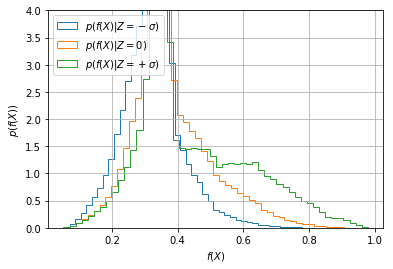

In [19]:
plt.hist(D.predict(make_X(200000, z=-1)), bins=50, density=1, histtype="step", label="$p(f(X)|Z=-\sigma)$")
plt.hist(D.predict(make_X(200000, z=0)), bins=50, density=1, histtype="step", label="$p(f(X)|Z=0)$")
plt.hist(D.predict(make_X(200000, z=1)), bins=50, density=1, histtype="step", label="$p(f(X)|Z=+\sigma)$")
plt.legend(loc="best")
plt.ylim(0,4)
plt.xlabel("$f(X)$")
plt.ylabel("$p(f(X))$")
plt.grid()
plt.legend(loc="upper left")
plt.savefig("f-adversary.pdf")
plt.show()

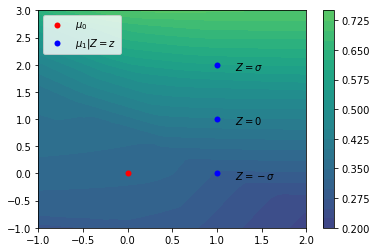

In [23]:
from scipy.interpolate import griddata


X_test = np.random.rand(25000, 2)
X_test[:, 0] *= 10. 
X_test[:, 0] -= 5.
X_test[:, 1] *= 10. 
X_test[:, 1] -= 5.

y_pred = D.predict(X_test).ravel()

xi = np.linspace(-1., 2., 100)
yi = np.linspace(-1., 3, 100)
gxi, gyi = np.meshgrid(xi, yi)
zi = griddata(X_test, y_pred, (gxi.ravel(), gyi.ravel()), method="linear")
CS = plt.contourf(xi, yi, zi.reshape(len(xi), len(yi)), 20, cmap=plt.cm.viridis,
                  vmax=1.0, vmin=0.0)

plt.colorbar() 
plt.scatter([0], [0], c="red", linewidths=0, label=r"$\mu_0$")
plt.scatter([1], [0], c="blue", linewidths=0, label=r"$\mu_1|Z=z$")
plt.scatter([1], [0+1], c="blue", linewidths=0)
plt.scatter([1], [0+2], c="blue", linewidths=0)
plt.text(1.2, 0-0.1, "$Z=-\sigma$", color="k")
plt.text(1.2, 1-0.1, "$Z=0$", color="k")
plt.text(1.2, 2-0.1, "$Z=\sigma$", color="k")
plt.xlim(-1,2)
plt.ylim(-1,3)
plt.legend(loc="upper left", scatterpoints=1)
plt.savefig("surface-adversary.pdf")
plt.show()

<Figure size 432x288 with 0 Axes>

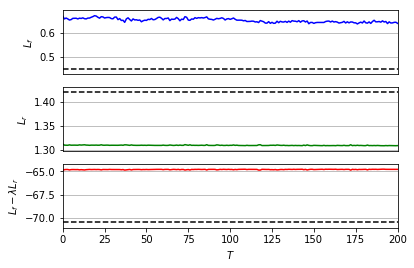

In [21]:
def plot_losses_final(losses):
    display.clear_output(wait=True)
    display.display(plt.gcf())
    
    n_iter = 200 #len(np.array(losses["L_f"]))-1

    ax1 = plt.subplot(311)  
    values = np.array(losses["L_f"])
    plt.plot(range(len(values)), values, color="blue")   
    plt.hlines(min_Lf, 0, n_iter, linestyles="dashed")
    low = min(min_Lf, values.min())
    high = max(min_Lf, values.max())
    #high = high - (high-low) * 0.3
    low, high = low - (high-low)*0.1, high + (high-low)*0.1
    plt.ylim(low, high)
    plt.xticks([])
    plt.xlim(0, n_iter)
    plt.grid()
    plt.ylabel(r"$L_f$")
    
    ax2 = plt.subplot(312, sharex=ax1) 
    values = np.array(losses["L_r"]) / lam
    plt.plot(range(len(values)), values, color="green")
    plt.hlines(min_Lr, 0, n_iter, linestyles="dashed")
    low = min(min_Lr, values.min())
    high = max(min_Lr, values.max())
    #high = high - (high-low) * 0.1
    low, high = low - (high-low)*0.1, high + (high-low)*0.1
    plt.ylim(low, high)
    plt.xlim(0, n_iter)
    plt.grid()
    plt.ylabel(r"$L_r$")
    
    ax3 = plt.subplot(313)
    values = np.array(losses["L_f - L_r"])
    plt.plot(range(len(values)), values, color="red")  
    plt.hlines(min_Lf - lam*min_Lr, 0, n_iter, linestyles="dashed")
    low = min(min_Lf - lam*min_Lr, values.min())
    high = max(min_Lf - lam*min_Lr, values.max())
    #low = low + (high-low) * 0.5
    low, high = low - (high-low)*0.1, high + (high-low)*0.1
    plt.ylim(low, high)
    plt.xlim(0, n_iter)
    plt.grid(axis="y")
    plt.ylabel("$L_f - \lambda L_r$")
    plt.xlabel("$T$")
    
    plt.savefig("training.pdf")
    
    plt.show()  
    
plt.rcParams["font.size"] = 10
plot_losses_final(losses)